<a href="https://colab.research.google.com/github/Aarushi-29/Fake_news_detection/blob/main/EDA_pre_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import wordcloud
from wordcloud import WordCloud
import statistics
from collections import Counter
import datetime
import textblob
from textblob import TextBlob
import sklearn

In [2]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Mounted at /content/gdrive


In [14]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

# Load scraped data from the specified directory
with open('/content/gdrive/My Drive/Fake_news_proj/scraped_articles.json') as json_data:
    scraped = json.load(json_data)

In [15]:
for i, site in enumerate((list(scraped['newspapers']))):
    articles = list(scraped['newspapers'][site]['articles'])
    if i == 0:
        df = pd.DataFrame.from_dict(articles)
        df["site"] = site
    else:
        new_df = pd.DataFrame.from_dict(articles)
        new_df["site"] = site
        df = pd.concat([df, new_df], ignore_index = True)


In [16]:
scraped = df
scraped["label"] = scraped["site"].apply(lambda x: "fake" if(x == "breitbart" or x == "infowars" or x == "theonion") else "true")
scraped.drop(labels=["link", "site"], axis = 1, inplace=True)

In [17]:
#Create column with labels
fake["label"] = "fake"
true["label"] = "true"

In [18]:
#Check shapes of dataframes. I scraped 1844 articles to add to this dataset.
print (fake.shape)
print (true.shape)
print (scraped.shape)

(23481, 5)
(21417, 5)
(767, 4)


In [19]:
#True news has location and publisher, which fake doesn't have. Remove for consistency
true["text"] = true['text'].apply(lambda x: x.partition("-")[2])

In [20]:
fake['date'] = pd.to_datetime(fake['date'], errors='coerce')
true['date'] = pd.to_datetime(true['date'], errors='coerce')

# Drop rows with missing date values
valid_fake = fake.dropna(subset=['date'])
valid_true = true.dropna(subset=['date'])

# Concatenate valid dataframes back together with the rest
fake_processed = pd.concat([valid_fake, fake[~fake.index.isin(valid_fake.index)]])
true_processed = pd.concat([valid_true, true[~true.index.isin(valid_true.index)]])

In [21]:
scraped["published"] = scraped["published"].apply(lambda x: x[0:10])
scraped["published"] = scraped["published"].apply(pd.to_datetime)

In [22]:
print (fake["subject"].unique())
print (true["subject"].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politicsNews' 'worldnews']


In [23]:
fake.drop("subject", axis=1, inplace=True)
true.drop("subject", axis=1, inplace=True)

In [24]:
scraped.rename(columns={"published": "date"}, inplace=True)
scraped_f = scraped[scraped["label"] == "fake"]
fake = pd.concat([fake,scraped_f], axis=0, ignore_index=True)

scraped_t = scraped[scraped["label"] == "true"]
true = pd.concat([true,scraped_t], axis=0, ignore_index=True)

In [25]:
true = true[true["text"] != ""]
fake = fake[fake["text"] != ""]

In [26]:
print(fake.shape)
print(true.shape)

(23727, 4)
(21936, 4)


In [27]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

In [28]:
fake.to_csv('fakeForModeling.csv')
!cp fakeForModeling.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [29]:
true.to_csv('trueForModeling.csv')
!cp trueForModeling.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [30]:
daily_true = pd.DataFrame(true.groupby("date").size())
daily_fake = pd.DataFrame(fake.groupby("date").size())
daily_true.reset_index(inplace=True)
daily_fake.reset_index(inplace=True)

In [31]:
daily_true.rename(columns={0: "Number of Articles_true"}, inplace=True)
daily_fake.rename(columns={0: "Number of Articles_fake"}, inplace=True)

In [32]:
from plotly.graph_objs import *
import plotly.graph_objects as go

layout = Layout(
    title='Number of Articles Published, Daily',
    xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text='Date')),
    yaxis = go.layout.YAxis(title = go.layout.yaxis.Title(text='Number of Articles')),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')

fig = go.Figure(layout=layout)
fig.add_scatter(x=daily_true['date'], y=daily_true['Number of Articles_true'],mode='lines', line_color='rgb(0,176,246)', name = "True News")
fig.add_scatter(x=daily_fake['date'], y=daily_fake['Number of Articles_fake'],mode='lines', name = "Fake News")
fig.show()

In [33]:
words_per_article_plot_t = true["text"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_article_plot_t)
words_per_article_t = words_per_article_plot_t.sum()/len(true["text"])

words_per_article_plot_f = fake["text"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_article_plot_f)
words_per_article_f = words_per_article_plot_f.sum()/len(fake["text"])

print ("The average number of words in a real news article is ", words_per_article_t)
print ("The average number of words in a fake news article is ", words_per_article_f)

print ("The standard deviation in real news article lengths is ", stdev_t)
print ("The standard deviation in fake news article lengths is ", stdev_f)

The average number of words in a real news article is  385.00250729394605
The average number of words in a fake news article is  424.19513634256333
The standard deviation in real news article lengths is  284.65389130096776
The standard deviation in fake news article lengths is  408.2694015744233


<ipython-input-34-2e41c17ba3ae>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-34-2e41c17ba3ae>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Number of Words in Fake News Article')

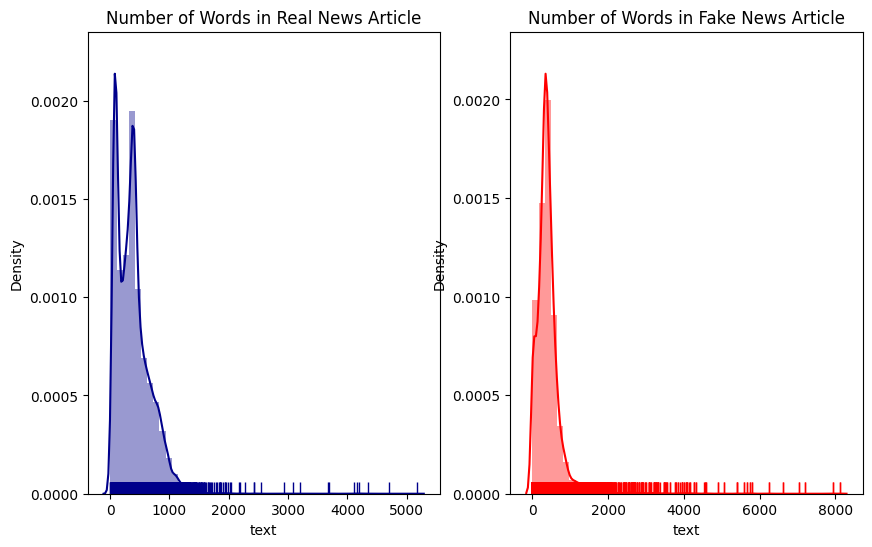

In [34]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(words_per_article_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Number of Words in Real News Article")
sns.distplot(words_per_article_plot_f, ax = ax[1], color = "red", rug = True).set_title("Number of Words in Fake News Article")

In [35]:
article_polarity_true = pd.DataFrame(columns=["article", "sentiment"])
for article in true["text"]:
    article = TextBlob(article)
    article_polarity_true = article_polarity_true.append(pd.Series([article,article.sentiment.polarity], index=article_polarity_true.columns), ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-35-5299d09c0f69>:4: FutureWarning:

The frame.append method is deprecated and will b

In [36]:
article_polarity_fake = pd.DataFrame(columns=["article", "sentiment"])
for article in fake["text"]:
    article = TextBlob(article)
    article_polarity_fake = article_polarity_fake.append(pd.Series([article,article.sentiment.polarity], index=article_polarity_fake.columns), ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-36-2f8b14d1f50b>:4: FutureWarning:

The frame.append method is deprecated and will b

In [37]:
print(statistics.mean(article_polarity_true["sentiment"]))
print(statistics.mean(article_polarity_fake["sentiment"]))

0.053624873037558
0.059436219676418926


<ipython-input-38-a02aed0c8fee>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-38-a02aed0c8fee>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Fake News Article Sentiments')

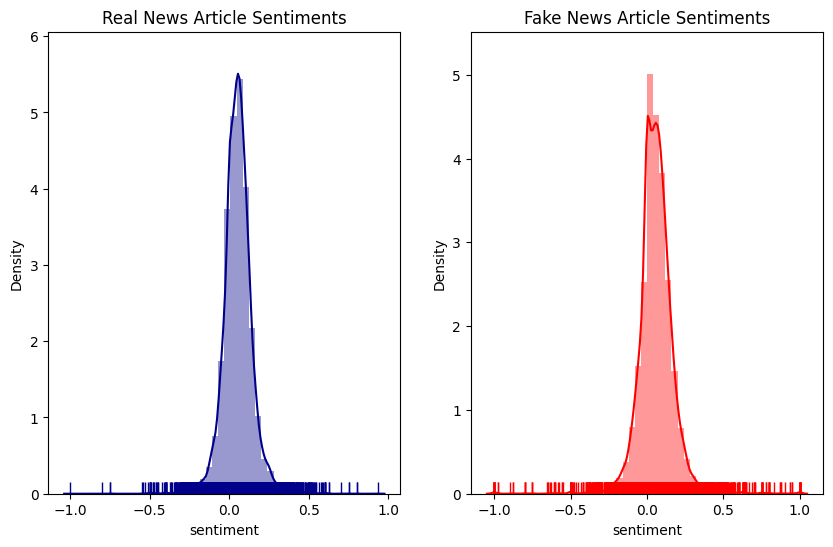

In [38]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(article_polarity_true["sentiment"], ax = ax[0], color = "darkblue", rug = True).set_title("Real News Article Sentiments")
sns.distplot(article_polarity_fake["sentiment"], ax = ax[1], color = "red", rug = True).set_title("Fake News Article Sentiments")

In [39]:
headline_polarity_true = pd.DataFrame(columns=["headline", "sentiment"])
for headline in true["title"]:
    headline = TextBlob(headline)
    headline_polarity_true = headline_polarity_true.append(pd.Series([headline,headline.sentiment.polarity], index=headline_polarity_true.columns), ignore_index=True)


Streaming output truncated to the last 5000 lines.
<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-39-036fcaadc3cd>:4: FutureWarning:

The frame.append method is deprecated and will b

In [40]:
#Most negative headlines
a = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][0])
b = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][1])
c = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = True, ignore_index=True)["headline"][2])

fig = go.Figure(data=[go.Table(header=dict(values=['Headline']),
                 cells=dict(values=[[a, b, c]]))])
fig.show()

In [41]:
a = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][0])
b = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][1])
c = str(headline_polarity_true.sort_values(by = ["sentiment"], ascending = False, ignore_index=True)["headline"][2])

fig = go.Figure(data=[go.Table(header=dict(values=['Headline']),
                 cells=dict(values=[[a, b, c]]))])
fig.show()

In [42]:
# Create an empty DataFrame to store headline polarity for fake headlines
headline_polarity_fake = pd.DataFrame(columns=["headline", "sentiment"])

# Calculate sentiment polarity for each fake headline and append to the DataFrame
for headline in fake["title"]:
    headline = TextBlob(headline)
    headline_polarity_fake = headline_polarity_fake.append(
        pd.Series([headline, headline.sentiment.polarity], index=headline_polarity_fake.columns),
        ignore_index=True
    )

# Calculate and print the mean sentiment polarity for fake headlines
mean_fake = statistics.mean(headline_polarity_fake["sentiment"])
print("Mean sentiment polarity for fake headlines:", mean_fake)


Streaming output truncated to the last 5000 lines.
<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will b

Mean sentiment polarity for fake headlines: 0.002683269244905251


<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-42-eb9b7d0343e1>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [43]:
# Create an empty DataFrame to store headline polarity for true headlines
headline_polarity_true = pd.DataFrame(columns=["headline", "sentiment"])

# Calculate sentiment polarity for each true headline and append to the DataFrame
for headline in true["title"]:
    headline = TextBlob(headline)
    headline_polarity_true = headline_polarity_true.append(
        pd.Series([headline, headline.sentiment.polarity], index=headline_polarity_true.columns),
        ignore_index=True
    )

# Calculate and print the mean sentiment polarity for true headlines
mean_true = statistics.mean(headline_polarity_true["sentiment"])
print("Mean sentiment polarity for true headlines:", mean_true)


Streaming output truncated to the last 5000 lines.
<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will b

Mean sentiment polarity for true headlines: 0.02511488359999369


<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-43-21bdef75b5ce>:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

<ipython-input-44-45855b43fd4e>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-44-45855b43fd4e>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, 'Fake News Headline Sentiments')

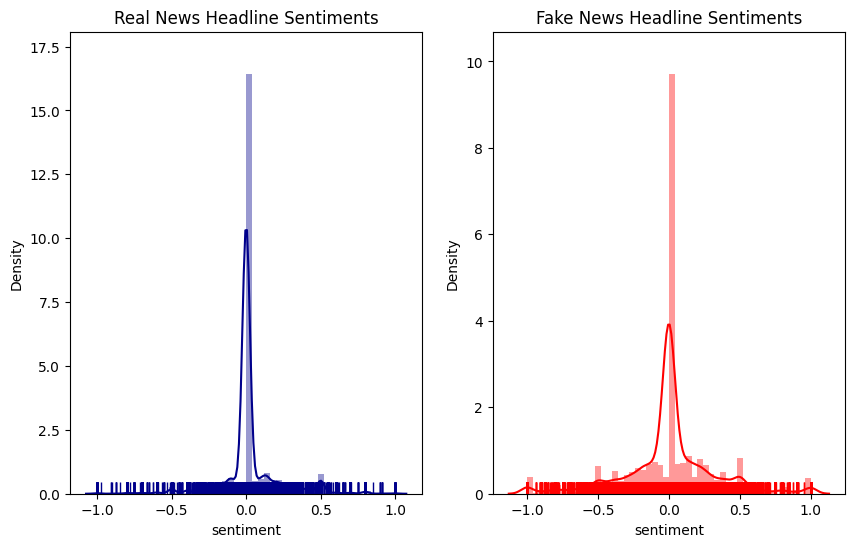

In [44]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(headline_polarity_true["sentiment"], ax = ax[0], color = "darkblue", rug = True).set_title("Real News Headline Sentiments")
sns.distplot(headline_polarity_fake["sentiment"], ax = ax[1], color = "red", rug = True).set_title("Fake News Headline Sentiments")


Tokenizing

In [45]:
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = list(stopwords.words('english', 'arabic'))
stop_words.extend(["said", "reuters", "CNN", "would", "image", "via"]) #extend stopwords to include these words too


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [46]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

words_in_t = [] #all tokens in true articles
words_in_f = [] #all tokens in fake articles
words_in_each_article_t = [] #list of true articles, each in tokenized form
words_in_each_article_f = [] #list of fake articles, each in tokenized form

def process(df, word_list, by_article_list):
  for article in (df["text"]):
    words = word_tokenize(article)
    words = [word.lower() for word in words if word.isalpha()] #lowercase
    words = [word for word in words if word not in string.punctuation and word not in stop_words] #punctuation, stopwords
    words = [lemmatizer.lemmatize(word) for word in words] #convert word to root form

    by_article_list.append(words)
    for w in words:
      word_list.append(w)

In [47]:
#NOTE: If rerunning, this cell will take a while
process(fake, words_in_f, words_in_each_article_f)

In [48]:
#NOTE: If rerunning, this cell will take a while
process(true, words_in_t, words_in_each_article_t)

In [49]:
from collections import Counter

bigrams_true = zip(words_in_t, words_in_t[1:])
bigram_counts_true = Counter(bigrams_true)
bigrams_true = pd.DataFrame(bigram_counts_true.most_common(20), columns=["Bigram", "Count"])
bigrams_true

,Bigram,Count
0,"(united, state)",12187
1,"(donald, trump)",10060
2,"(white, house)",8402
3,"(president, donald)",5834
4,"(north, korea)",5655
5,"(prime, minister)",4250
6,"(new, york)",3751
7,"(last, year)",3494
8,"(islamic, state)",3389
9,"(last, week)",3386


In [50]:
bigrams_false = zip(words_in_f, words_in_f[1:])
bigram_counts_false = Counter(bigrams_false)
bigrams_false = pd.DataFrame(bigram_counts_false.most_common(20), columns=["Bigram", "Count"])
bigrams_false

,Bigram,Count
0,"(donald, trump)",15456
1,"(hillary, clinton)",6790
2,"(white, house)",6398
3,"(united, state)",6272
4,"(new, york)",4253
5,"(president, obama)",3861
6,"(president, trump)",3795
7,"(fox, news)",3260
8,"(barack, obama)",2244
9,"(trump, supporter)",1927


In [51]:
trigrams_true = zip(words_in_t, words_in_t[1:], words_in_t[2:])
trigram_counts_true = Counter(trigrams_true)
trigrams_true = pd.DataFrame(trigram_counts_true.most_common(20), columns=["Trigram", "Count"])
trigrams_true

,Trigram,Count
0,"(president, donald, trump)",5773
1,"(president, barack, obama)",2903
2,"(respond, request, comment)",865
3,"(president, vladimir, putin)",796
4,"(state, rex, tillerson)",673
5,"(secretary, state, rex)",672
6,"(national, security, adviser)",643
7,"(former, president, barack)",629
8,"(russian, president, vladimir)",615
9,"(speaker, paul, ryan)",607


In [52]:
trigrams_false = zip(words_in_f, words_in_f[1:], words_in_f[2:])
trigram_counts_false = Counter(trigrams_false)
trigrams_false = pd.DataFrame(trigram_counts_false.most_common(20), columns=["Trigram", "Count"])
trigrams_false

,Trigram,Count
0,"(donald, trump, realdonaldtrump)",1692
1,"(new, york, time)",1534
2,"(black, life, matter)",1252
3,"(president, donald, trump)",1041
4,"(news, century, wire)",939
5,"(president, united, state)",915
6,"(president, barack, obama)",886
7,"(century, wire, say)",733
8,"(video, screen, capture)",729
9,"(new, york, city)",613


In [53]:
wordcounts_t = Counter(words_in_t)
wordcounts_f = Counter(words_in_f)

In [54]:

mostcommon_t = Counter(wordcounts_t).most_common(20)
mostcommon_f = Counter(wordcounts_f).most_common(20)

t_plot = dict(mostcommon_t)
mostcommon_t = pd.DataFrame(mostcommon_t, columns = ["Word", "Count"])
mostcommon_t = mostcommon_t.reset_index(drop=True)
mostcommon_t = mostcommon_t['Word'].tolist()

f_plot = dict(mostcommon_f)
mostcommon_f = pd.DataFrame(mostcommon_f, columns = ["Word", "Count"])
mostcommon_f = mostcommon_f.reset_index(drop=True)
mostcommon_f = mostcommon_f['Word'].tolist()


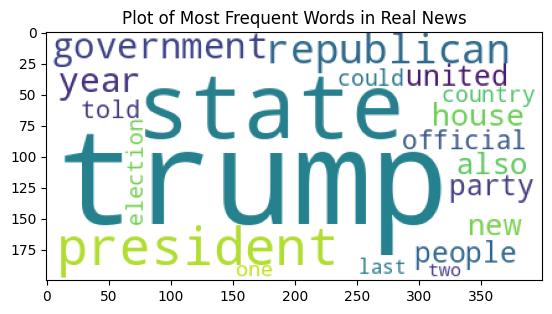

In [55]:
t_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(t_plot)

plt.imshow(t_wc)
plt.title("Plot of Most Frequent Words in Real News")
plt.show()


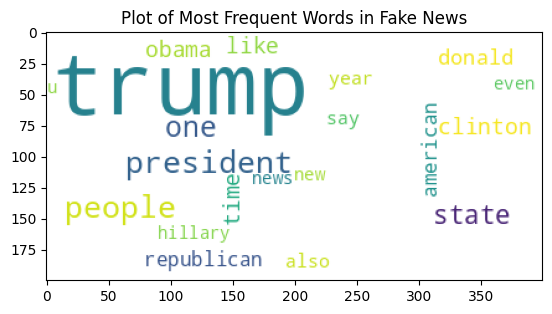

In [56]:
f_wc = WordCloud(max_words=25,relative_scaling=1,background_color ='white', normalize_plurals=False).generate_from_frequencies(f_plot)

plt.imshow(f_wc)
plt.title("Plot of Most Frequent Words in Fake News")
plt.show()


In [57]:
#Of the top 20 words in each class, 9 words are common
len(set(mostcommon_t) & set(mostcommon_f))

9

In [58]:
#Get tokenized forms of all articles (true and fake) in one dataframe
X = []
for a in words_in_each_article_t:
  X.append(a)
for b in words_in_each_article_f:
  X.append(b)

In [59]:
#Get labels of all articles (true and fake) in one dataframe
y = pd.concat([true["label"], fake["label"]])
y = [1 if x == "fake" else 0 for x in y] #1 and 0 for ease of tokenizing

In [60]:
articles = pd.DataFrame(X)
y = pd.DataFrame(y, columns=["label"])


In [61]:
articles.to_csv('articles.csv')
!cp articles.csv "/content/gdrive/My Drive/Fake_news_proj/"

y.to_csv('labels.csv')
!cp labels.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [62]:
import sklearn.model_selection as ms

#Create 80-20 train test split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Keep words that appear in greater than 10% of documents. Override preprocessor and implement on list of words
# in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df=0.1, preprocessor=' '.join)

# Implement on train dataset
response_train = tfidf.fit_transform(X_train)  # This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names_out()  # Correct way to get feature names
dense_train = response_train.todense()  # This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()


In [65]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train


,according,act,action,added,administration,agency,already,also,america,american,...,went,whether,white,without,woman,work,world,year,yet,york
0,0.000000,0.0,0.000000,0.0,0.000000,0.127821,0.0,0.077245,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.159959,0.000000,0.000000
1,0.000000,0.0,0.000000,0.0,0.077142,0.000000,0.0,0.000000,0.0,0.000000,...,0.091124,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
2,0.105947,0.0,0.125167,0.0,0.000000,0.000000,0.0,0.075306,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.233916,0.000000,0.000000
3,0.113932,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.065064,0.00000,0.000000,0.0,0.041924,0.070272,0.000000
4,0.101904,0.0,0.000000,0.0,0.053762,0.119857,0.0,0.036216,0.0,0.000000,...,0.000000,0.057204,0.000000,0.000000,0.00000,0.000000,0.0,0.037498,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36525,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
36526,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.244089,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.144125,0.000000,0.000000
36527,0.000000,0.0,0.000000,0.0,0.221074,0.246430,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.194158,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
36528,0.076824,0.0,0.090761,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.068031,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.113078,0.000000,0.280257


In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=' '.join, vocabulary=feature_names_train)

# Fit the vectorizer on the training data and then transform the test data
tfidf.fit(X_train)
response_test = tfidf.transform(X_test)  # Now use transform() on test data
dense_test = response_test.todense()  # This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=' '.join, vocabulary=feature_names_train)

# Fit the vectorizer on the training data and then transform the test data
tfidf.fit(X_train)
feature_names_test = tfidf.get_feature_names_out()  # Get feature names for test data
response_test = tfidf.transform(X_test)
dense_test = response_test.todense()
denselist_test = dense_test.tolist()

In [71]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test

,according,act,action,added,administration,agency,already,also,america,american,...,went,whether,white,without,woman,work,world,year,yet,york
0,0.047317,0.000000,0.000000,0.000000,0.000000,0.0,0.055918,0.000000,0.000000,0.000000,...,0.0,0.0,0.043848,0.108087,0.0,0.000000,0.100166,0.000000,0.000000,0.057538
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.118184,0.071084,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.075701,0.000000,0.094311,...,0.0,0.0,0.000000,0.000000,0.0,0.111134,0.225454,0.000000,0.131378,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.057401,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.178300,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.180120,0.000000,0.000000,...,0.0,0.0,0.234830,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9129,0.000000,0.000000,0.000000,0.000000,0.291348,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.096043,0.000000,0.000000,0.000000,0.000000
9130,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.033016,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.239296,0.000000,0.000000
9131,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.073265,0.107323,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.109099,0.151716,0.000000,0.250679


In [72]:
#This is the final data to be used for training models
df_train.to_csv('training_data.csv')
!cp training_data.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [73]:
#This is the final data to be used for testing models
df_test.to_csv('testing_data.csv')
!cp testing_data.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [74]:
y_train = pd.DataFrame(y_train, columns=["label"])
y_test = pd.DataFrame(y_test, columns=["label"])


In [75]:
#Final labels to be used for training models
y_train.to_csv('train_labels.csv')
!cp train_labels.csv "/content/gdrive/My Drive/Fake_news_proj/"

In [76]:
#Final labels to be used for testing models
y_test.to_csv('test_labels.csv')
!cp test_labels.csv "/content/gdrive/My Drive/Fake_news_proj/"